In [229]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2

In [230]:
sift = cv2.xfeatures2d.SIFT_create()

def ratio_match(query, query_keys, query_desc, display_train, actual_train, ratio, reverseColors=False):
    train_keys, train_desc = sift.detectAndCompute(actual_train, None)
    
    bf = cv2.BFMatcher(crossCheck=False)
    matches = bf.knnMatch(query_desc, train_desc, k=2)
    
    # apply ratio test
    under_threshold = []
    for m1, m2 in matches:
        if m1.distance < ratio * m2.distance:
            under_threshold.append(m1)
    
    point_color = (255, 0, 0) if reverseColors else (0, 0, 255)
    match_color = (0, 0, 255) if reverseColors else (255, 0, 0)
    matches_img = cv2.drawMatches(query, query_keys, display_train, train_keys, under_threshold,
                                  outImg=None, matchColor=match_color,
                                  singlePointColor=point_color)
    
    return matches_img

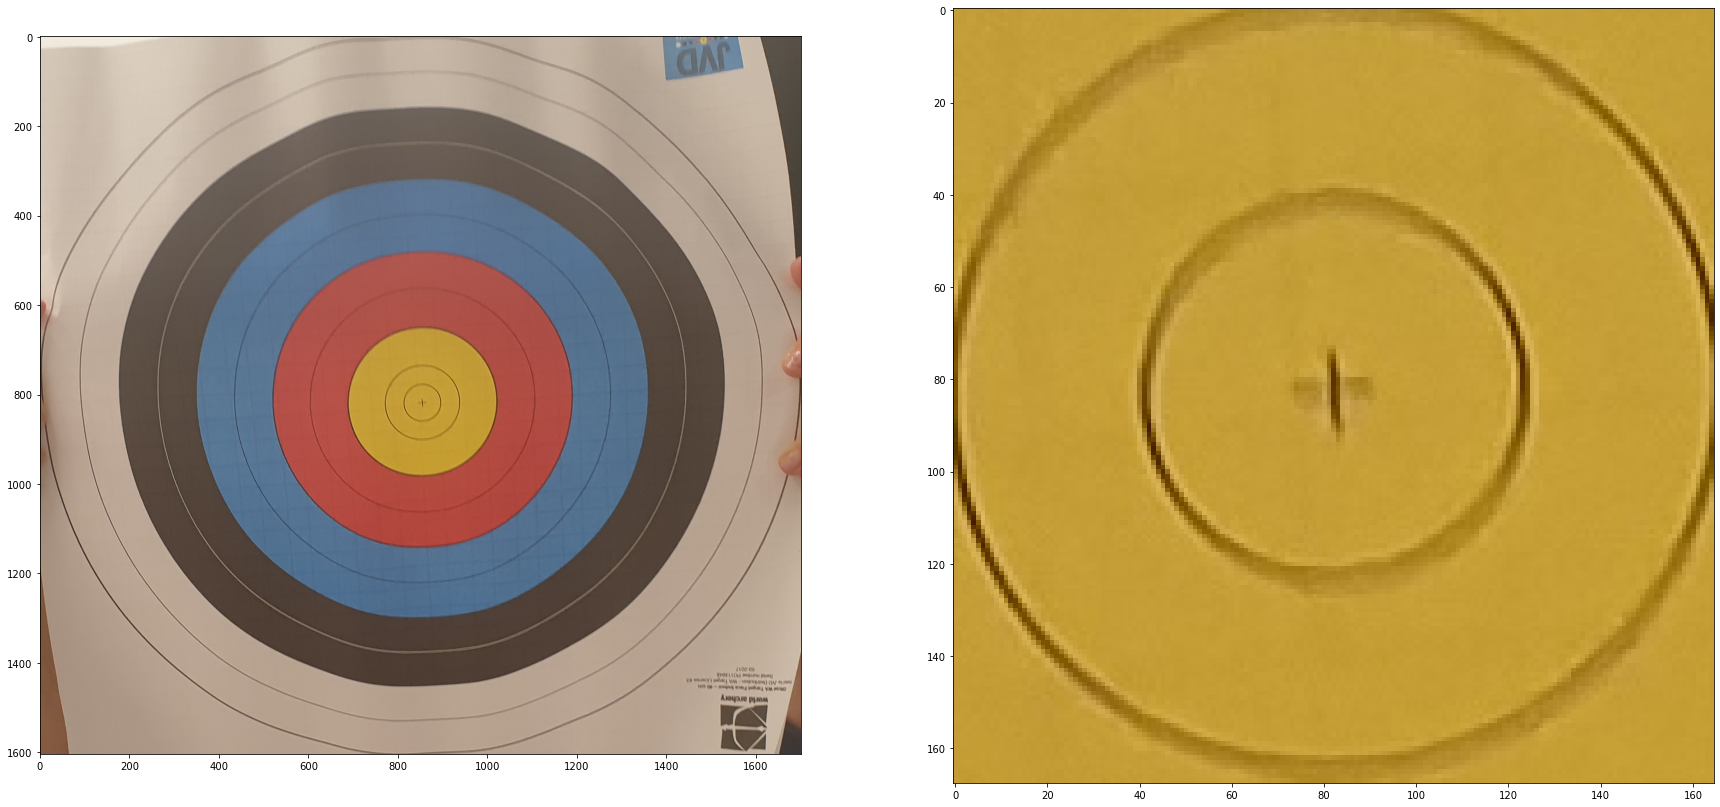

In [231]:
# set the model image
test_images_amount = 6
model_image = cv2.imread(str(test_images_amount) + '.jpg')
model_image = cv2.cvtColor(model_image, cv2.COLOR_BGR2RGB)
  
# crop the target
height, width, _ = model_image.shape

def crop(img, top, left, bottom, right):
    left_pixels = int(left * width / 100)
    right_pixels = int(right * width / 100)
    top_pixels = int(top * height / 100)
    bottom_pixels = int(bottom * height / 100)
    img = img[top_pixels:height - bottom_pixels,
              left_pixels:width - right_pixels]
    
    return img

# crop and display the target face and the bull'seye
target_face = crop(model_image, 15.41, 31.69, 31.58, 26.16)
bullseye = crop(model_image, 39.76, 50.84, 54.72, 45.11)
fig = plt.figure(figsize=(30, 30))
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
ax0.imshow(target_face)
ax1.imshow(bullseye)

# calculate keypoints and description for both the target face and the bull'seye
target_keys, target_desc = sift.detectAndCompute(target_face, None)
bullseye_keys, bullseye_desc = sift.detectAndCompute(bullseye, None)

In [234]:
# load all test images
source_images = list()
critical_images = list()

print('Loading images...')
for i in range(test_images_amount):
    img = cv2.imread(str(i) + '.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    critical_img = img.copy()
    train_height, train_width, _ = img.shape
    
    # find largest circle in the image and crop it accordingly
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 200, 100)
    circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, dp=1, minDist=30,
                               param1=200 ,param2=200 ,minRadius=0 ,maxRadius=0)
    
    # find the largest circle and crop it out of the image
    if type(circles) != type(None):
        circles = np.uint16(np.around(circles))
        print(len(circles[0]), 'circle(s) found.')
        circles = sorted(circles[0], key=lambda x: x[2])[::-1]
        
        # filter out the circles that are entirely contained inside the image
        # also find the one with the largest radius
        contained_circles = list()
        largest_rad = 0
        for circ in circles:
            x = circ[0]
            y = circ[1]
            r = circ[2]
            
            if x >= r and y >= r and x + r <= train_width and y + r <= train_height:
                contained_circles.append(circ)
                
                # found new largest radius
                if r > largest_rad:
                    largest_rad = r
                
        print(len(contained_circles), 'from which are contained inside the image.')
        print('largest radius is', largest_rad)
        
        if len(contained_circles) > 0:
            rad_threshold = .8
            for circ in contained_circles:
                x = circ[0]
                y = circ[1]
                r = circ[2]
                
                # filter out the top largest circles
                if r >= rad_threshold * largest_rad:
                    # paint the circle over the source image
                    cv2.circle(img, (x, y), r, (0, 255, 0), 10)

                    # leave the target face and zero out every other pixel
                    dx = np.arange(train_width)
                    dy = np.arange(train_height)
                    X, Y = np.meshgrid(dx, dy)
                    distances = ((X - x) ** 2 + (Y - y) ** 2) ** .5
                    critical_img[distances > r] = 255
    else:
        print('Found no circles.')

    # save images
    source_images.append(img)
    critical_images.append(critical_img)
    
print('Done.')

Loading images...
4 circle(s) found.
4 from which are contained inside the image.
largest radius is 816
45 circle(s) found.
16 from which are contained inside the image.
largest radius is 768
262 circle(s) found.
205 from which are contained inside the image.
largest radius is 1184
40 circle(s) found.
40 from which are contained inside the image.
largest radius is 1161
12 circle(s) found.
12 from which are contained inside the image.
largest radius is 476
346 circle(s) found.
90 from which are contained inside the image.
largest radius is 530
Done.


Running...
Calculating match #1
Calculating match #2
Calculating match #3
Calculating match #4
Calculating match #5
Calculating match #6
Done.


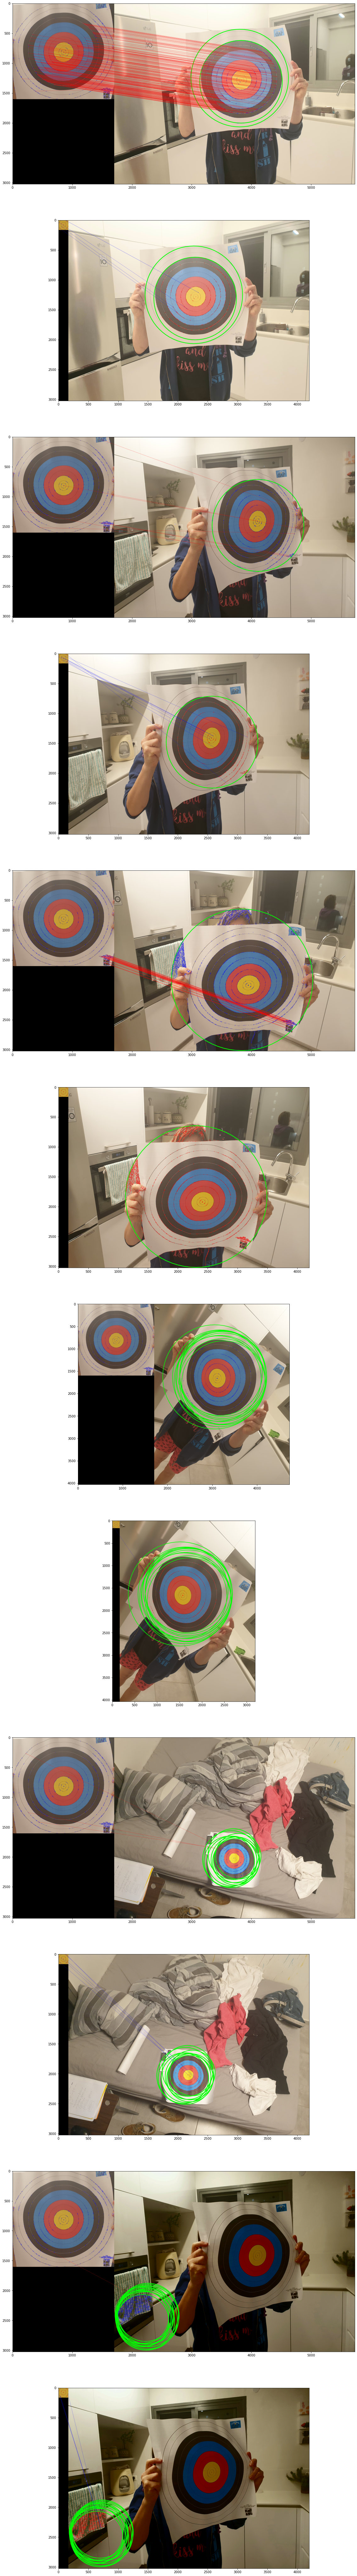

In [235]:
print('Running...')

# create subplots
fig = plt.figure(figsize=(150,150))
axles = [fig.add_subplot(test_images_amount * 2, 1, i + 1) for i in range(test_images_amount * 2)]

# calculate and display the matches
axles_index = 0
for i in range(len(source_images)):
    print('Calculating match #' + str(int(axles_index / 2 + 1)))
    target_match = ratio_match(target_face, target_keys, target_desc, source_images[i], critical_images[i], .6)
    bullseye_match = ratio_match(bullseye, bullseye_keys, bullseye_desc, source_images[i], critical_images[i], .85, reverseColors=True)
    axles[axles_index].imshow(target_match)
    axles[axles_index + 1].imshow(bullseye_match)
    axles_index += 2
    
print('Done.')